In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import datetime
import matplotlib.dates as mdates
import seaborn as sns; sns.set()
sns.set_context("poster",font_scale=1.2,rc={"font":"helvetica"});
sns.set_style("white"); #sns.set_style("ticks")
cp = sns.color_palette("colorblind") #sns.palplot(current_palette)
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib.pyplot as plt
import sys
sys.path.append("../src/")

import getpass
# Remove gks paths (not needed for anyone else)
if getpass.getuser()=="gks":
    try:
        sys.path.remove("/Users/gks/Dropbox/mypylib/notebooks/GIT/transitMCMC/src")
        sys.path.remove("/Users/gks/Dropbox/mypylib")
    except Exception as e:
        print(e)
        print("Paths already removed")

In [2]:
from priors import PriorSet, UP, NP, JP
import tf
import pyde
import mcmc_utils
from exotk.utils.likelihood import ll_normal_ev_py, ll_normal_es, ll_normal_ev
import batman
import math
import epicblsmulti
import k2help
import utils

# Get K2 data

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 206318379.
('Transitmask:', array([], dtype=int64))
Using *GP* to flatten (can be 'GP', 'Median', or default to SavGol)
there can still be leftover bad points, so sigma clipping is recommended
Also might be good to rerun with transitmask set
WARNING [astropy._showwarning()]: Input data contains invalid values (NaNs or infs), which were automatically masked.


/Users/gks/anaconda/lib/python2.7/site-packages/astropy/stats/sigma_clipping.py:158: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/Users/gks/anaconda/lib/python2.7/site-packages/astropy/stats/sigma_clipping.py:159: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value


3386
3330
Using period range [ 1. 50.]
Overwriting: df= [9.8e-05] fmin= 0.02 freq_range [0.02 1.  ]
Computing bls...
=====Results====
Best period: 2.26050002261
Best freq: 0.44238
Depth: 0.00431379865714
Epoch: 2144.9920223184486
Number of transits: 30
Optimization terminated successfully.
('Per=', 2.2604373106175024, 'epoch=', 2144.9902420830567)


../src/k2help.py:232: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df_exo.set_value(0,"pl_hostname","EPIC "+str(self.s.id))
../src/k2help.py:233: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df_exo.set_value(0,"pl_name","EPIC "+str(self.s.id))
../src/k2help.py:235: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df_exo.set_value(0,"ra_str",utils.radecDeg2hourangleHMS(self.s.k2_ra,self.s.k2_dec,sep_doubledots=False)[0])
../src/k2help.py:237: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df_exo.set_value(0,"dec_str",utils.radecDeg2hourangleHMS(self.s.k2_ra,self.s.k2_dec,sep_doubledots=False)[1])
../src/k2help.py:238: FutureWarning: set_value is deprecated and will be re

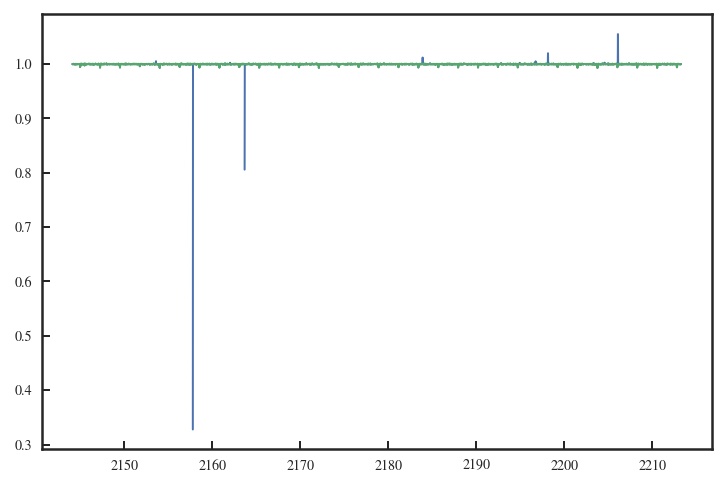

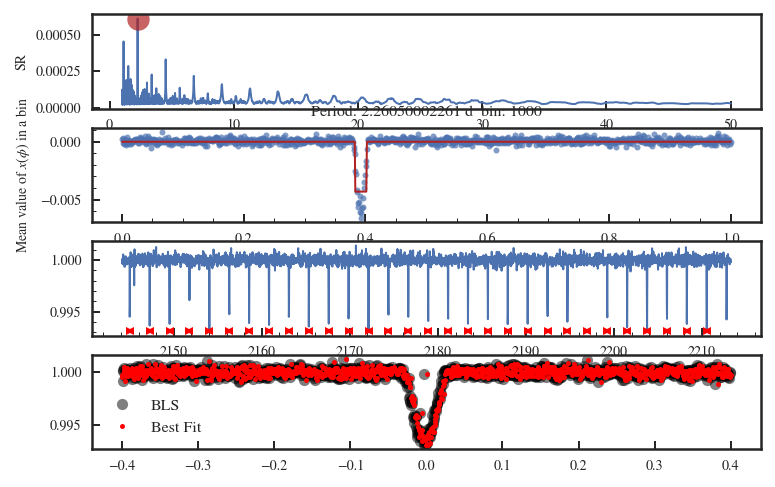

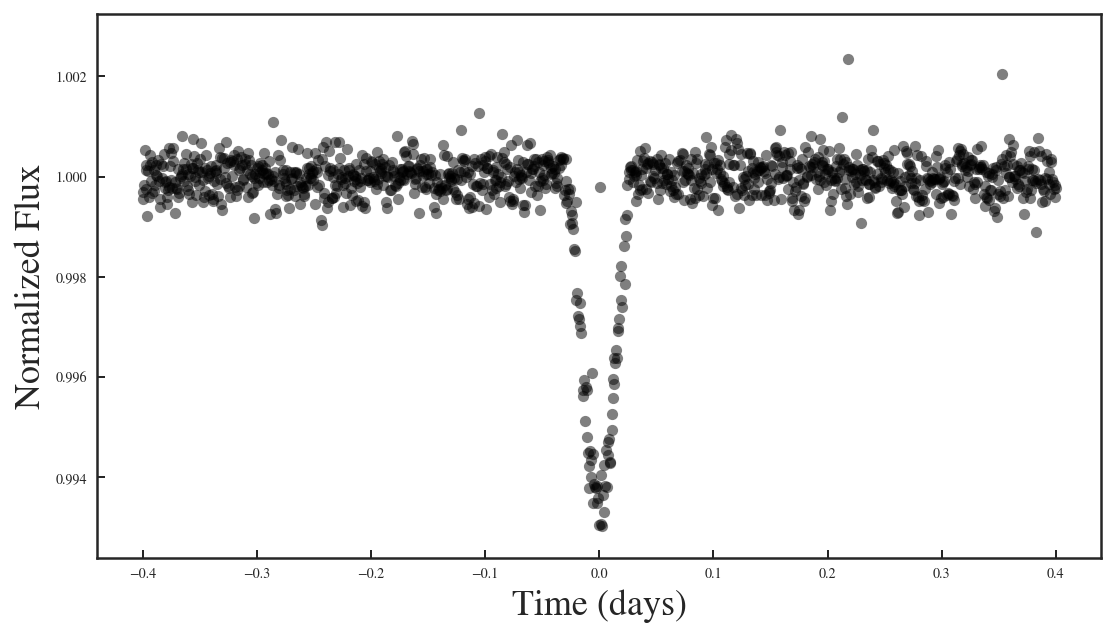

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 206318379.
('Transitmask:', array([1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 2584, 2585,
       2586, 2587, 2588, 2589, 2590, 2591, 2592,   39,   40,   41,   42,
         43,   44,   45,   46,   47,   48, 1588, 1589, 1590, 1591, 1592,
       1593, 1594, 1595, 1596, 1597, 3137, 3138, 3139, 3140, 3141, 3142,
       3143, 3144, 3145, 3146,  592,  593,  594,  595,  596,  597,  598,
        599,  600,  601, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148,
       2149, 2150, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153,
       1154, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703,
        150,  151,  152,  153,  154,  155,  156,  157,  158, 1699, 1700,
       1701, 1702, 1703, 1704, 1705, 1706, 1707, 3247, 3248, 3249, 3250,
       3251, 3252, 3253, 3254, 3255, 3256,  703,  704,  705,  706,  707,
        708,  709,  710,  711,  712, 2252, 2253, 2254, 22

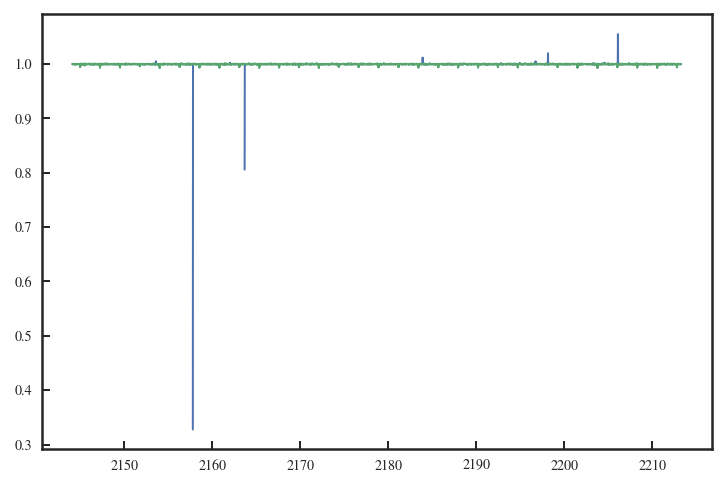

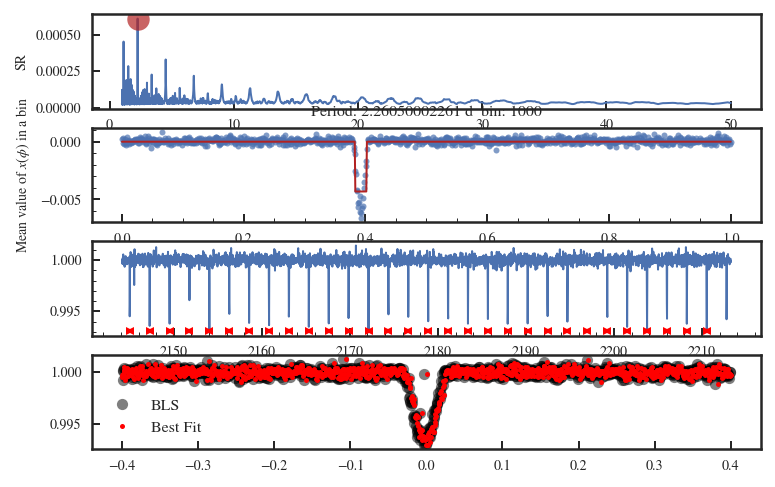

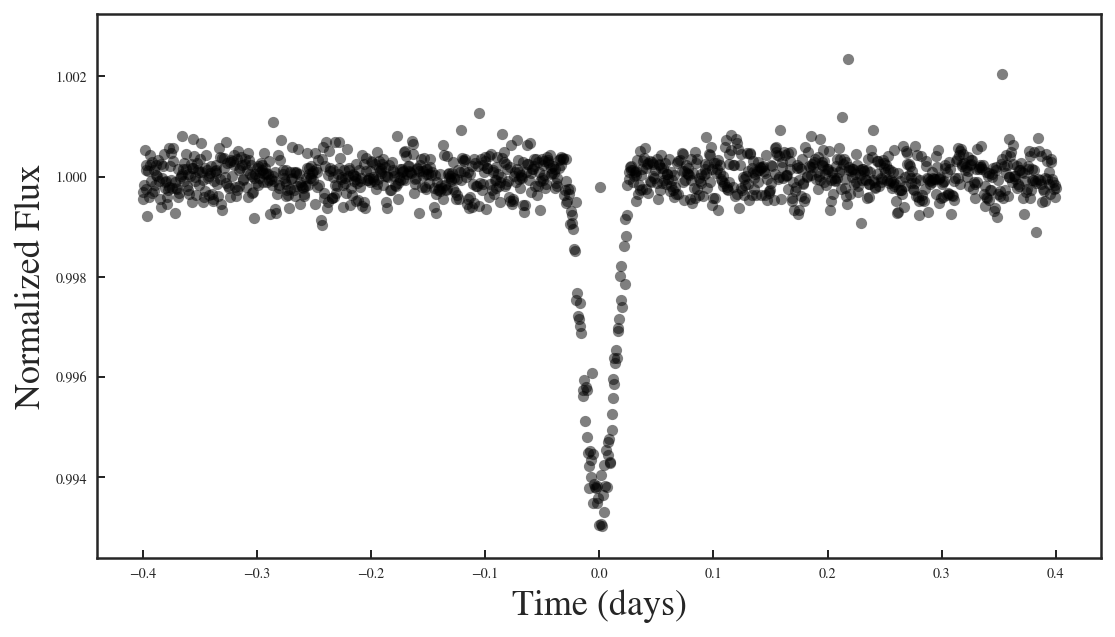

In [3]:
DUR = 0.2
EP = epicblsmulti.EVERESTBLS(206318379,sigma=15,sigma_upper=2.,flatten_method="GP")
planet = EP(dur=DUR)
EP = epicblsmulti.EVERESTBLS(206318379,sigma=15,sigma_upper=2.,flatten_method="GP",transitmask=EP.star.transitmask)
planet = EP(dur=DUR)

('Using planet with t0=', 2144.990239353385, 'and P=', 2.260437208157793)
Using median filtered data -- assumes you have run that from beginning!


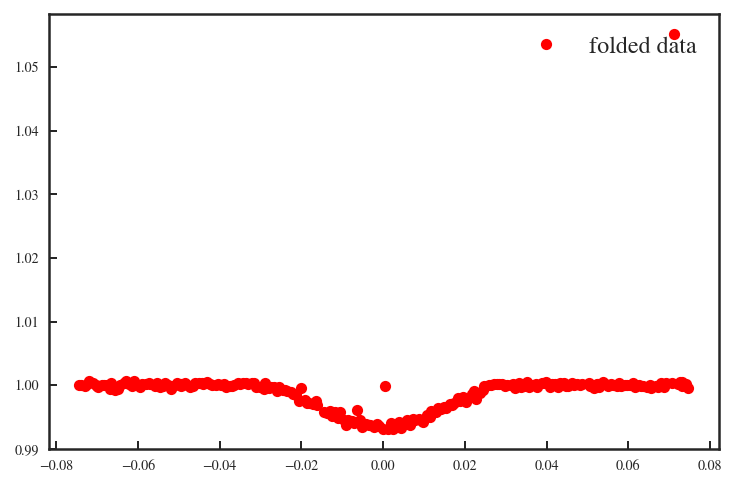

In [4]:
#t_ufold, f_ufold, t_fold, f_fold = EP.cutout_transits(dur=0.4)
df = EP.get_cutout_phased_df(dur=0.15,sigma=None)
df = df.reset_index(drop=True)
df= df.sort_values("x")

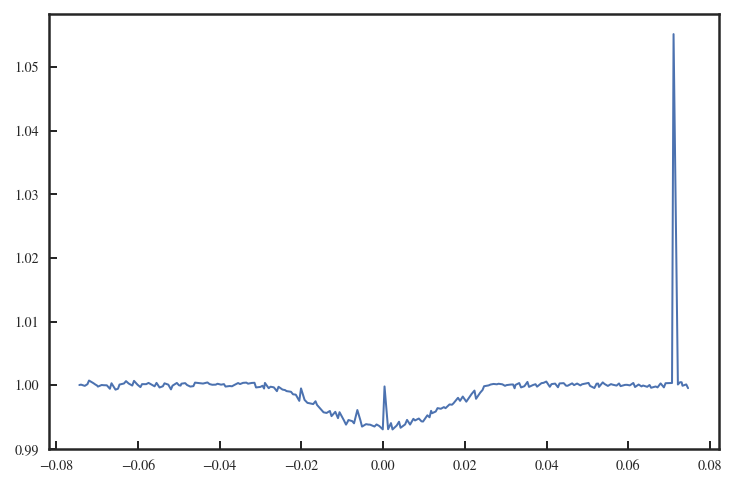

In [5]:
plt.plot(df.x.values,df.y.values)

224
[ 83 103 113 217]
220


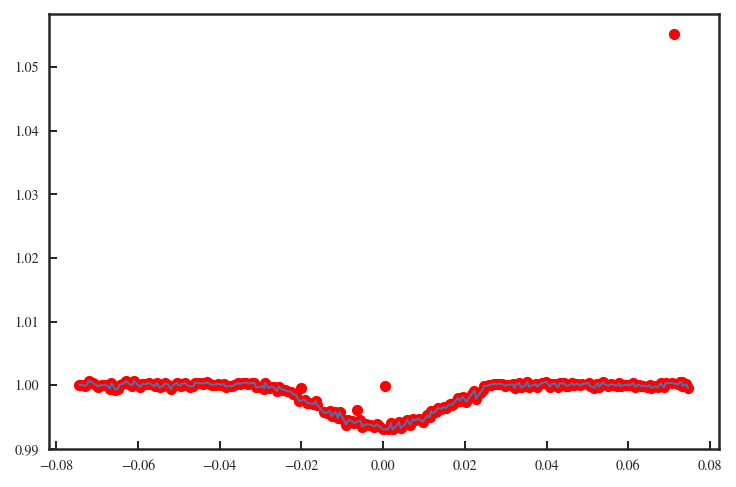

In [7]:
t,f,m,mm = k2help.median_filter_and_sigma_clip(df.x.values,df.y.values,return_mask=True,sigma=3,window=31)
print(len(df))
print(m)
plt.plot(df.x, df.y,"r.")
dfmm= df.drop(m)
t_fold_final = dfmm.x
f_fold_final = dfmm.y
plt.plot(dfmm.x,dfmm.y)
print(len(dfmm))

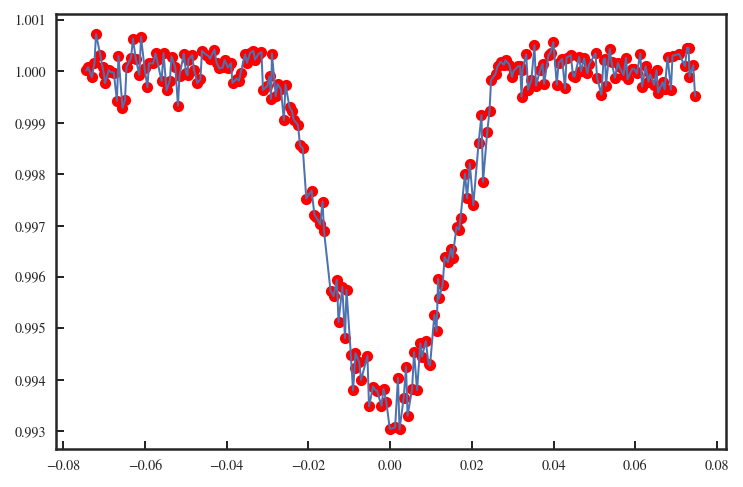

In [8]:
dfmm_s = dfmm.sort_index()
dfmm_s["time"] = dfmm_s.time.values + k2help.KEPLER_JD_OFFSET
plt.plot(dfmm_s.x,dfmm_s.y,"r.")
plt.plot(dfmm.x,dfmm.y)
dfmm_s = dfmm_s.sort_values("time")

# Read Ground Based 

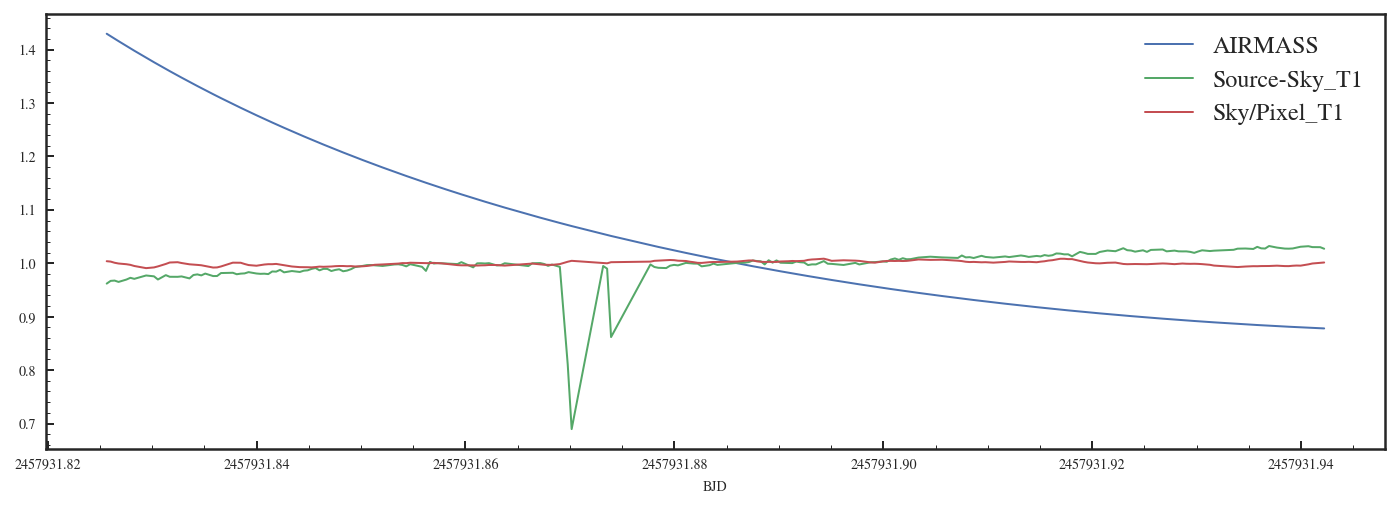

In [9]:
df_ground = pd.read_csv("../data/k2_28b/Processed_K2-28b-diffuserin-30s_measurements.xls",sep="\t")
# Take out bad sky points
df_ground = df_ground[0:-20]

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df_ground.BJD_TDB,utils.norm_median(df_ground.AIRMASS))
ax.plot(df_ground.BJD_TDB,utils.norm_median(df_ground["Source-Sky_T1"]))
ax.plot(df_ground.BJD_TDB,((utils.norm_median(df_ground["Sky/Pixel_T1"])-1)*0.1)+1.)

ax.set_xlabel("BJD")
ax.legend(loc="upper right",fontsize=12)
ax.minorticks_on()

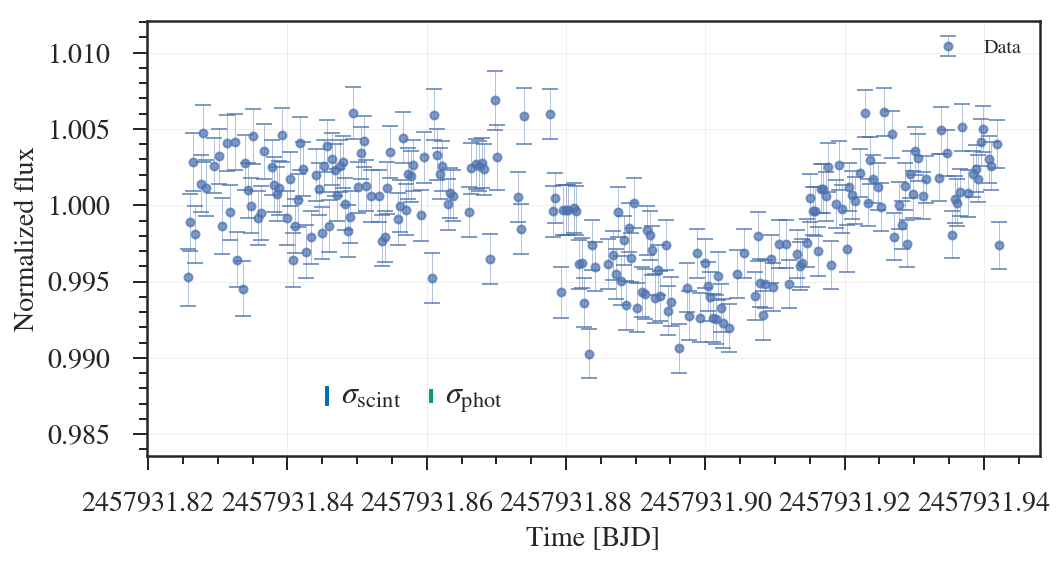

In [19]:
import plot_transits
fig, ax = plt.subplots(figsize=(8,4))
plot_transits.plot_transit_with_model(t_ground,f_ground,tot_error,ax=ax)
x0 = t_ground[0]
ax.errorbar(x0+0.01+0.01,0.9975-0.01,yerr=final_unbinned_scint_noise,elinewidth=2,color=cp[0],mew=0.5)
ax.errorbar(x0+0.025+0.01,0.9975-0.01,yerr=final_unbinned_phot_noise,elinewidth=2,color=cp[1],mew=0.5)
ax.text(x0+0.01+0.01+0.002,0.99741-0.0104,r"$\sigma_{\mathrm{scint}}$",fontsize=16)
ax.text(x0+0.025+0.01+0.002,0.99741-0.0104,r"$\sigma_{\mathrm{phot}}$",fontsize=16)

ax.set_xlabel("Time [BJD]",fontsize=14)
ax.set_ylabel("Normalized flux",fontsize=14)
ax.minorticks_on()
ax.legend(loc="upper right",fontsize=10)
ax.margins(x=0.05,y=0.15)
ax.grid(lw=0.5,alpha=0.3)

ax.tick_params(axis="both",labelsize=14)

### Calculate Scintillation errorbars

In [10]:
# Define variables
t_ground = df_ground.BJD_TDB.values
f_ground = df_ground.rel_flux_T1.values/np.nanmedian(df_ground.rel_flux_T1.values)
err_ground = df_ground.rel_flux_err_T1.values/np.nanmedian(df_ground.rel_flux_T1.values)

# Other params
NREFSTARS = 3.
cadence = np.median(np.diff(t_ground))*24.*60.*60.
print("Cadence {}s".format(cadence))

# Calculate the mean values for scintillation and photon to plot on the plot
final_unbinned_scint_noise = utils.scintillation_noise(350.,np.mean(df_ground["AIRMASS"]),cadence,2700.,withextra=True)*np.sqrt(1.+1./NREFSTARS)
final_unbinned_phot_noise = np.mean(df_ground.rel_flux_err_T1)
print("Mean photon error: {}".format(final_unbinned_phot_noise))
print("Mean scint error: {}".format(final_unbinned_scint_noise))

# Calculate full array of errors including scintilation
scint_error = utils.scintillation_noise(350.,df_ground.AIRMASS.values,cadence,2700.,withextra=True)*np.sqrt(1.+1./NREFSTARS)
tot_error = np.sqrt(scint_error**2.+err_ground**2.)

Cadence 32.5728267431s
Mean photon error: 0.000451928909953
Mean scint error: 0.000635806262651


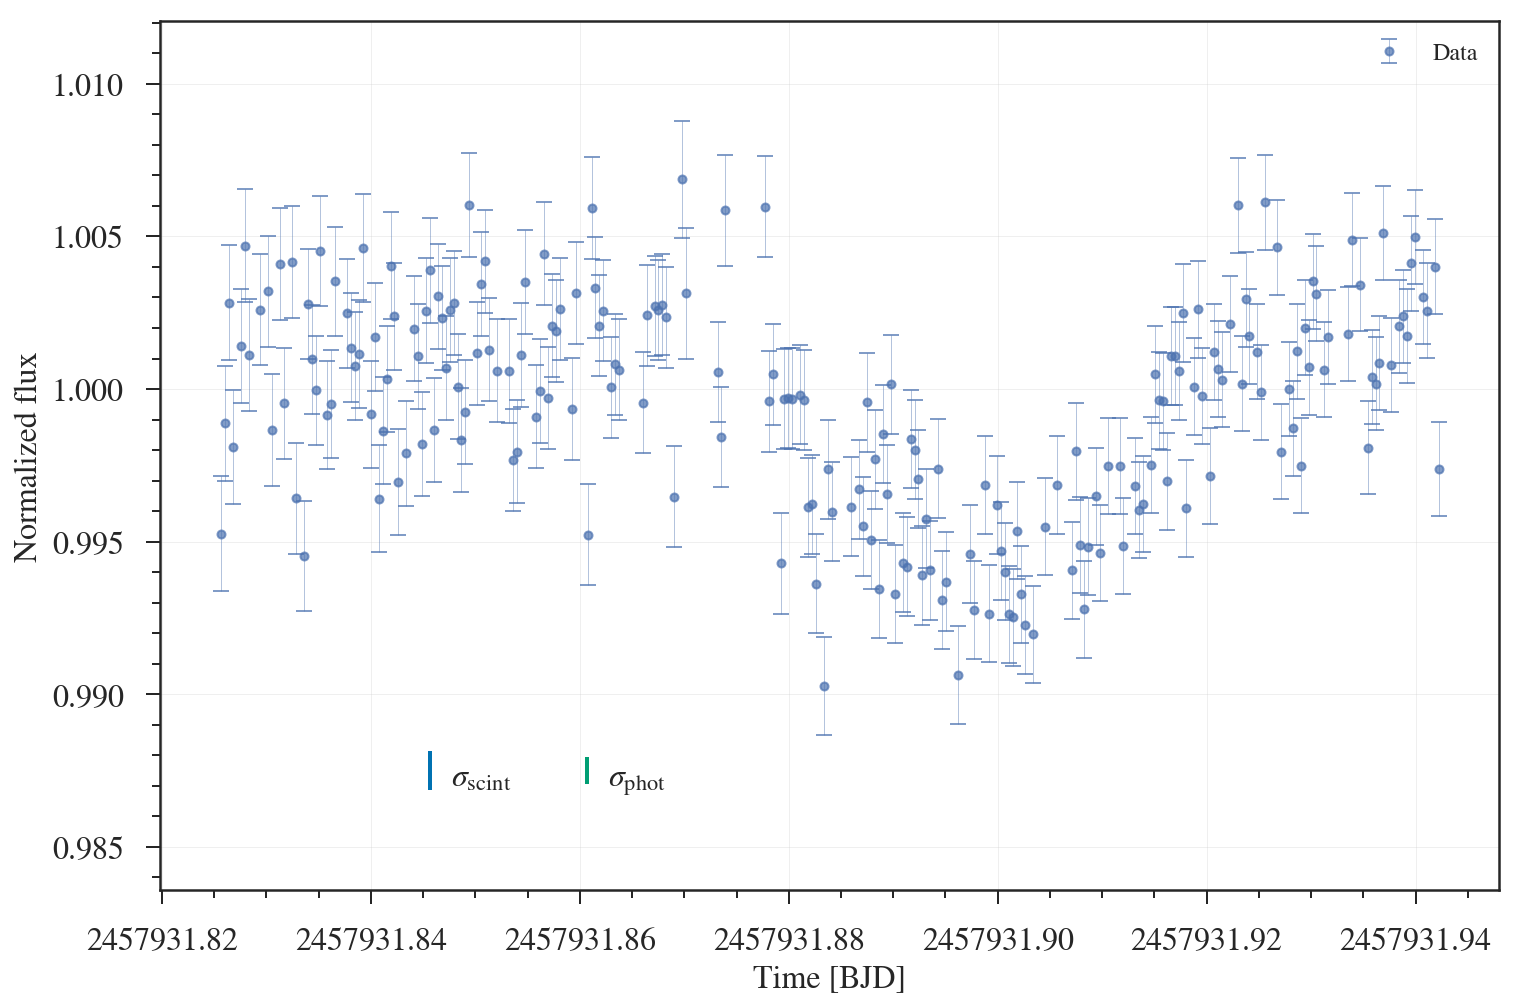

In [11]:
import plot_transits
fig, ax = plt.subplots(figsize=(12,8))
plot_transits.plot_transit_with_model(t_ground,f_ground,tot_error,ax=ax)
x0 = t_ground[0]
ax.errorbar(x0+0.01+0.01,0.9975-0.01,yerr=final_unbinned_scint_noise,elinewidth=2,color=cp[0],mew=0.5)
ax.errorbar(x0+0.025+0.01,0.9975-0.01,yerr=final_unbinned_phot_noise,elinewidth=2,color=cp[1],mew=0.5)
ax.text(x0+0.01+0.01+0.002,0.99741-0.0104,r"$\sigma_{\mathrm{scint}}$",fontsize=16)
ax.text(x0+0.025+0.01+0.002,0.99741-0.0104,r"$\sigma_{\mathrm{phot}}$",fontsize=16)

ax.set_xlabel("Time [BJD]",fontsize=16)
ax.set_ylabel("Normalized flux",fontsize=16)
ax.minorticks_on()
ax.legend(loc="upper right",fontsize=12)
ax.margins(x=0.05,y=0.15)
ax.grid(lw=0.5,alpha=0.3)

ax.tick_params(axis="both",labelsize=16)

In [12]:
#import astropylib

ii   = planet.get_attributeAndError("_pl_orbincl")[0:2]
pp   = planet.get_attributeAndError("_pl_orbper")[0:2]
rprs = planet.get_attributeAndError("_pl_ratror")[0:2]
aRs  = planet.get_attributeAndError("_pl_ratdor")[0:2]

_p = np.log10(pp[0])
_t0   = planet.get_attributeAndError("_pl_tranmid")[0]

print("log(P)",mcmc_utils.err_logP_from_p(pp))
print("cos(i)",mcmc_utils.err_cosi_from_i(ii))
print("RpRs",rprs)
print("log(aRs)",mcmc_utils.err_logaRs_from_aRs(aRs))
print(_p)
print(_t0)

log(P) [0.3541924474334233, nan]
cos(i) [0.005432684798786842, nan]
RpRs (0.07446521431014846, nan)
log(aRs) [1.3168087280927998, nan]
0.3541924474334233
2456977.9902393534


In [35]:
class LPFunction(object):
    """
    Log-Likelihood function class
    
    General philosophy:
    — Modify this for each fit
    — Outputs will be passed to emcee.sampler()
    — Outside of this are functions to plot the MCMC chains and corner plots
       
    NOTES:
    Based on hpprvi's awesome class, see: https://github.com/hpparvi/exo_tutorials
    
    I extended the Prior and Priorset classes in 
    /Users/gks/.local/lib/python2.7/site-packages/exotk
    """
    def __init__(self):
        """
        Note: number_pv_baseline must be set to whatever the index of the 'fraw' parameter is
        """
        # This is only performed during initialization
        self.data1= {"time"  : dfmm_s.time.values,  # phase folded time in days (centered on 0)
                    "flux"   : dfmm_s.y.values   # phase folded flux
                    }
        self.data2= {"time" : t_ground,
                     "flux" : f_ground,
                     "error": tot_error
                    }
        #####
        
        # Setting priors
        self.priors = [UP( 2457931.90-0.05     , 2457931.90+0.05        , 'tc'       ,r'$T_C$'                ,priortype="model"),  ##   5 - Transit centre, Tc
                       #UP( _t0 -0.001          , _t0+0.001              , 'tc'       ,r'$T_C$'                 ,priortype="model"),  ##   4 - Transit centre, Tc
                       UP( _p  -0.002          , _p  +0.002             , 'logP'     ,r'$\log(P)$'             ,priortype="model"),  ##   0 - log(P)
                       UP( 0.                  , 0.2                    , 'cos(i)'   ,r'$\cos(i)$'             ,priortype="model"),  ##   1 - cos(i)
                       UP( 0.0                 , 0.1                    , 'RpRs_1'   ,r'$R_p/R_s$1'             ,priortype="model"),  ##   6 - rp/rstar
                       UP( 0.9                 , 2.0                    , 'log(a/Rs)',r'$\log(a/R_s)$2'         ,priortype="model"),  ##   2 - log(a/rstar)
                       UP( 0.0                 , 0.1                    , 'RpRs_2'   ,r'$R_p/R_s$2'            ,priortype="model"),  ##   7 - rp/rstar
                       #UP( 0.                  , 1.                     , 'q1_1'     ,r'$q_1$1'                ,priortype="model"),  ##   8 - q1
                       #UP( 0.                  , 1.                     , 'q2_1'     ,r'$q_2$1'                ,priortype="model"),  ##   9 - q2
                       #UP( 0.                  , 1.                     , 'q1_2'     ,r'$q_1$2'                ,priortype="model"),  ##   10 - q1
                       #UP( 0.                  , 1.                     , 'q2_2'     ,r'$q_2$2'                ,priortype="model"),  ##   11 - q2
                       UP( 0.9                 , 1.1                    , 'fraw1'    ,r'fraw1'                 ,priortype="baseline1"),## 12 - Baseline constant
                       UP( 0.9                 , 1.1                    , 'fraw2'    ,r'fraw2'                 ,priortype="baseline2"),
                       UP( 1e-5                , 50e-5                  , 'err1'     ,r'error1'                ,priortype="error1")]## 13 - Baseline constant
        
        self.ps     = PriorSet(self.priors)
        print("Baseline1 is at pv=",self.pv_lab2Idx("fraw1"))
        print("Baseline2 is at pv=",self.pv_lab2Idx("fraw2"))
        print("Error is at pv=",self.pv_lab2Idx("err1"))
        
    def pv_lab2Idx(self,pv_label):
        return np.where(np.array(self.ps.labels)==pv_label)[0][0]
            
    def compute_transit(self,pv,times1=None,times2=None):
        """
        Calls BATMAN and returns the transit model
        
        INPUT:
        pv    - parameters passed to the function 
        times - times, and array of timestamps 
        
        OUTPUT:
        lc - the lightcurve model at *times*
        """
        # First transit, K2
        self.params1 = batman.TransitParams()
        self.params1.t0 = pv[self.pv_lab2Idx("tc")]
        self.params1.per = 10.**pv[self.pv_lab2Idx("logP")]
        self.params1.inc = np.arccos(pv[self.pv_lab2Idx("cos(i)")])*180./math.pi
        self.params1.rp = pv[self.pv_lab2Idx("RpRs_1")]
        self.params1.a = 10.**pv[self.pv_lab2Idx("log(a/Rs)")]
        self.params1.ecc = 0.
        self.params1.w = 0.
        #q1, q2 = pv[self.pv_lab2Idx("q1_1")], pv[self.pv_lab2Idx("q2_1")]
        #self.params1.u = mcFunc.u1_u2_from_q1_q2(q1,q2) # Kipping 2013 formalism
        self.params1.u = [0.4266, 0.3076]
        self.params1.limb_dark = "quadratic"
        self.params1.fp = 0.001
        if times1 is None:
            times1 = self.data1["time"]
        transitmodel = batman.TransitModel(self.params1, times1, transittype='primary',supersample_factor=7,exp_time=0.020431801470066003)
        self.lc1 = transitmodel.light_curve(self.params1)
        
        # Second transit, ground,
        self.params2 = batman.TransitParams()
        self.params2.t0 = pv[self.pv_lab2Idx("tc")]
        self.params2.per = 10.**pv[self.pv_lab2Idx("logP")]
        self.params2.inc = np.arccos(pv[self.pv_lab2Idx("cos(i)")])*180./math.pi
        self.params2.rp = pv[self.pv_lab2Idx("RpRs_2")]
        self.params2.a = 10.**pv[self.pv_lab2Idx("log(a/Rs)")]
        self.params2.ecc = 0.
        self.params2.w = 0.
        #q1, q2 = pv[self.pv_lab2Idx("q1_2")], pv[self.pv_lab2Idx("q2_2")]
        #self.params2.u = mcFunc.u1_u2_from_q1_q2(q1,q2) # Kipping 2013 formalism
        self.params2.u = [0.3402,0.3156]
        self.params2.limb_dark = "quadratic"
        self.params2.fp = 0.001
        if times2 is None:
            times2 = self.data2["time"]
        transitmodel = batman.TransitModel(self.params2, times2, transittype='primary')
        self.lc2 = transitmodel.light_curve(self.params2)
        return self.lc1, self.lc2      
    
    def detrend(self,pv):
        """
        A function to detrend.
        
        INPUT:
            pv - an array containing a sample draw of the parameters defined in self.lpf.ps
        
        OUTPUT:
            detrend/pv[self.number_pv_baseline] - the additional trend in the data (no including transit)
        """
        detrend = np.zeros(len(self.data2["flux"]))
        
        # loop over detrend parameters
        for i in self.ps.get_param_type_indices(paramtype="detrend"):
            detrend += pv[i]*(self.data2[self.ps.labels[i]]-1.)
        return detrend/pv[self.pv_lab2Idx("fraw2")]
        
    def compute_lc_model(self,pv):
        """
        Compute the light curve model with detrend
        
        INPUT:
            pv - an array containing a sample draw of the parameters defined in self.lpf.ps
        
        OUTPUT:
            The full light curve model with a trend
        """
        f1, f2 = self.compute_transit(pv)
        # Return the flux from K2, and then detrended flux from ground
        return f1, f2 + self.detrend(pv)
                    
    def __call__(self,pv):
        """
        Return the log likelihood
        NOTES:
            This is done each time an instance is called
        """
        # If priors are outside of bounds, return -inf
        if any(pv < self.ps.pmins) or any(pv>self.ps.pmaxs):
            return -np.inf
        # make sure that sqrtecosw is well behaved
        flux_m1, flux_m2 = self.compute_lc_model(pv)
        
        # Return the log-likelihood
        log_of_priors = self.ps.c_log_prior(pv)
        
        scaled_flux1  = self.data1["flux"]/pv[self.pv_lab2Idx("fraw1")]
        scaled_flux2  = self.data2["flux"]/pv[self.pv_lab2Idx("fraw2")]
        
        log_of_model1  = ll_normal_es(scaled_flux1, flux_m1, pv[self.pv_lab2Idx("err1")])
        log_of_model2  = ll_normal_ev(scaled_flux2, flux_m2, self.data2["error"])

        log_ln = log_of_priors + log_of_model1 + log_of_model2
        
        return log_ln

In [36]:
# Initialize an instance of the Transit Fitter Class, using the LPFunction as defined above
import trf
TF = trf.TransitFit(LPFunction)

Baseline1 is at pv= 6
Baseline2 is at pv= 7
Error is at pv= 8


In [33]:
#TF.minimize_PyDE(mcmc=False)

In [34]:
#TF.lpf.ps.plot_all(TF.min_pv)

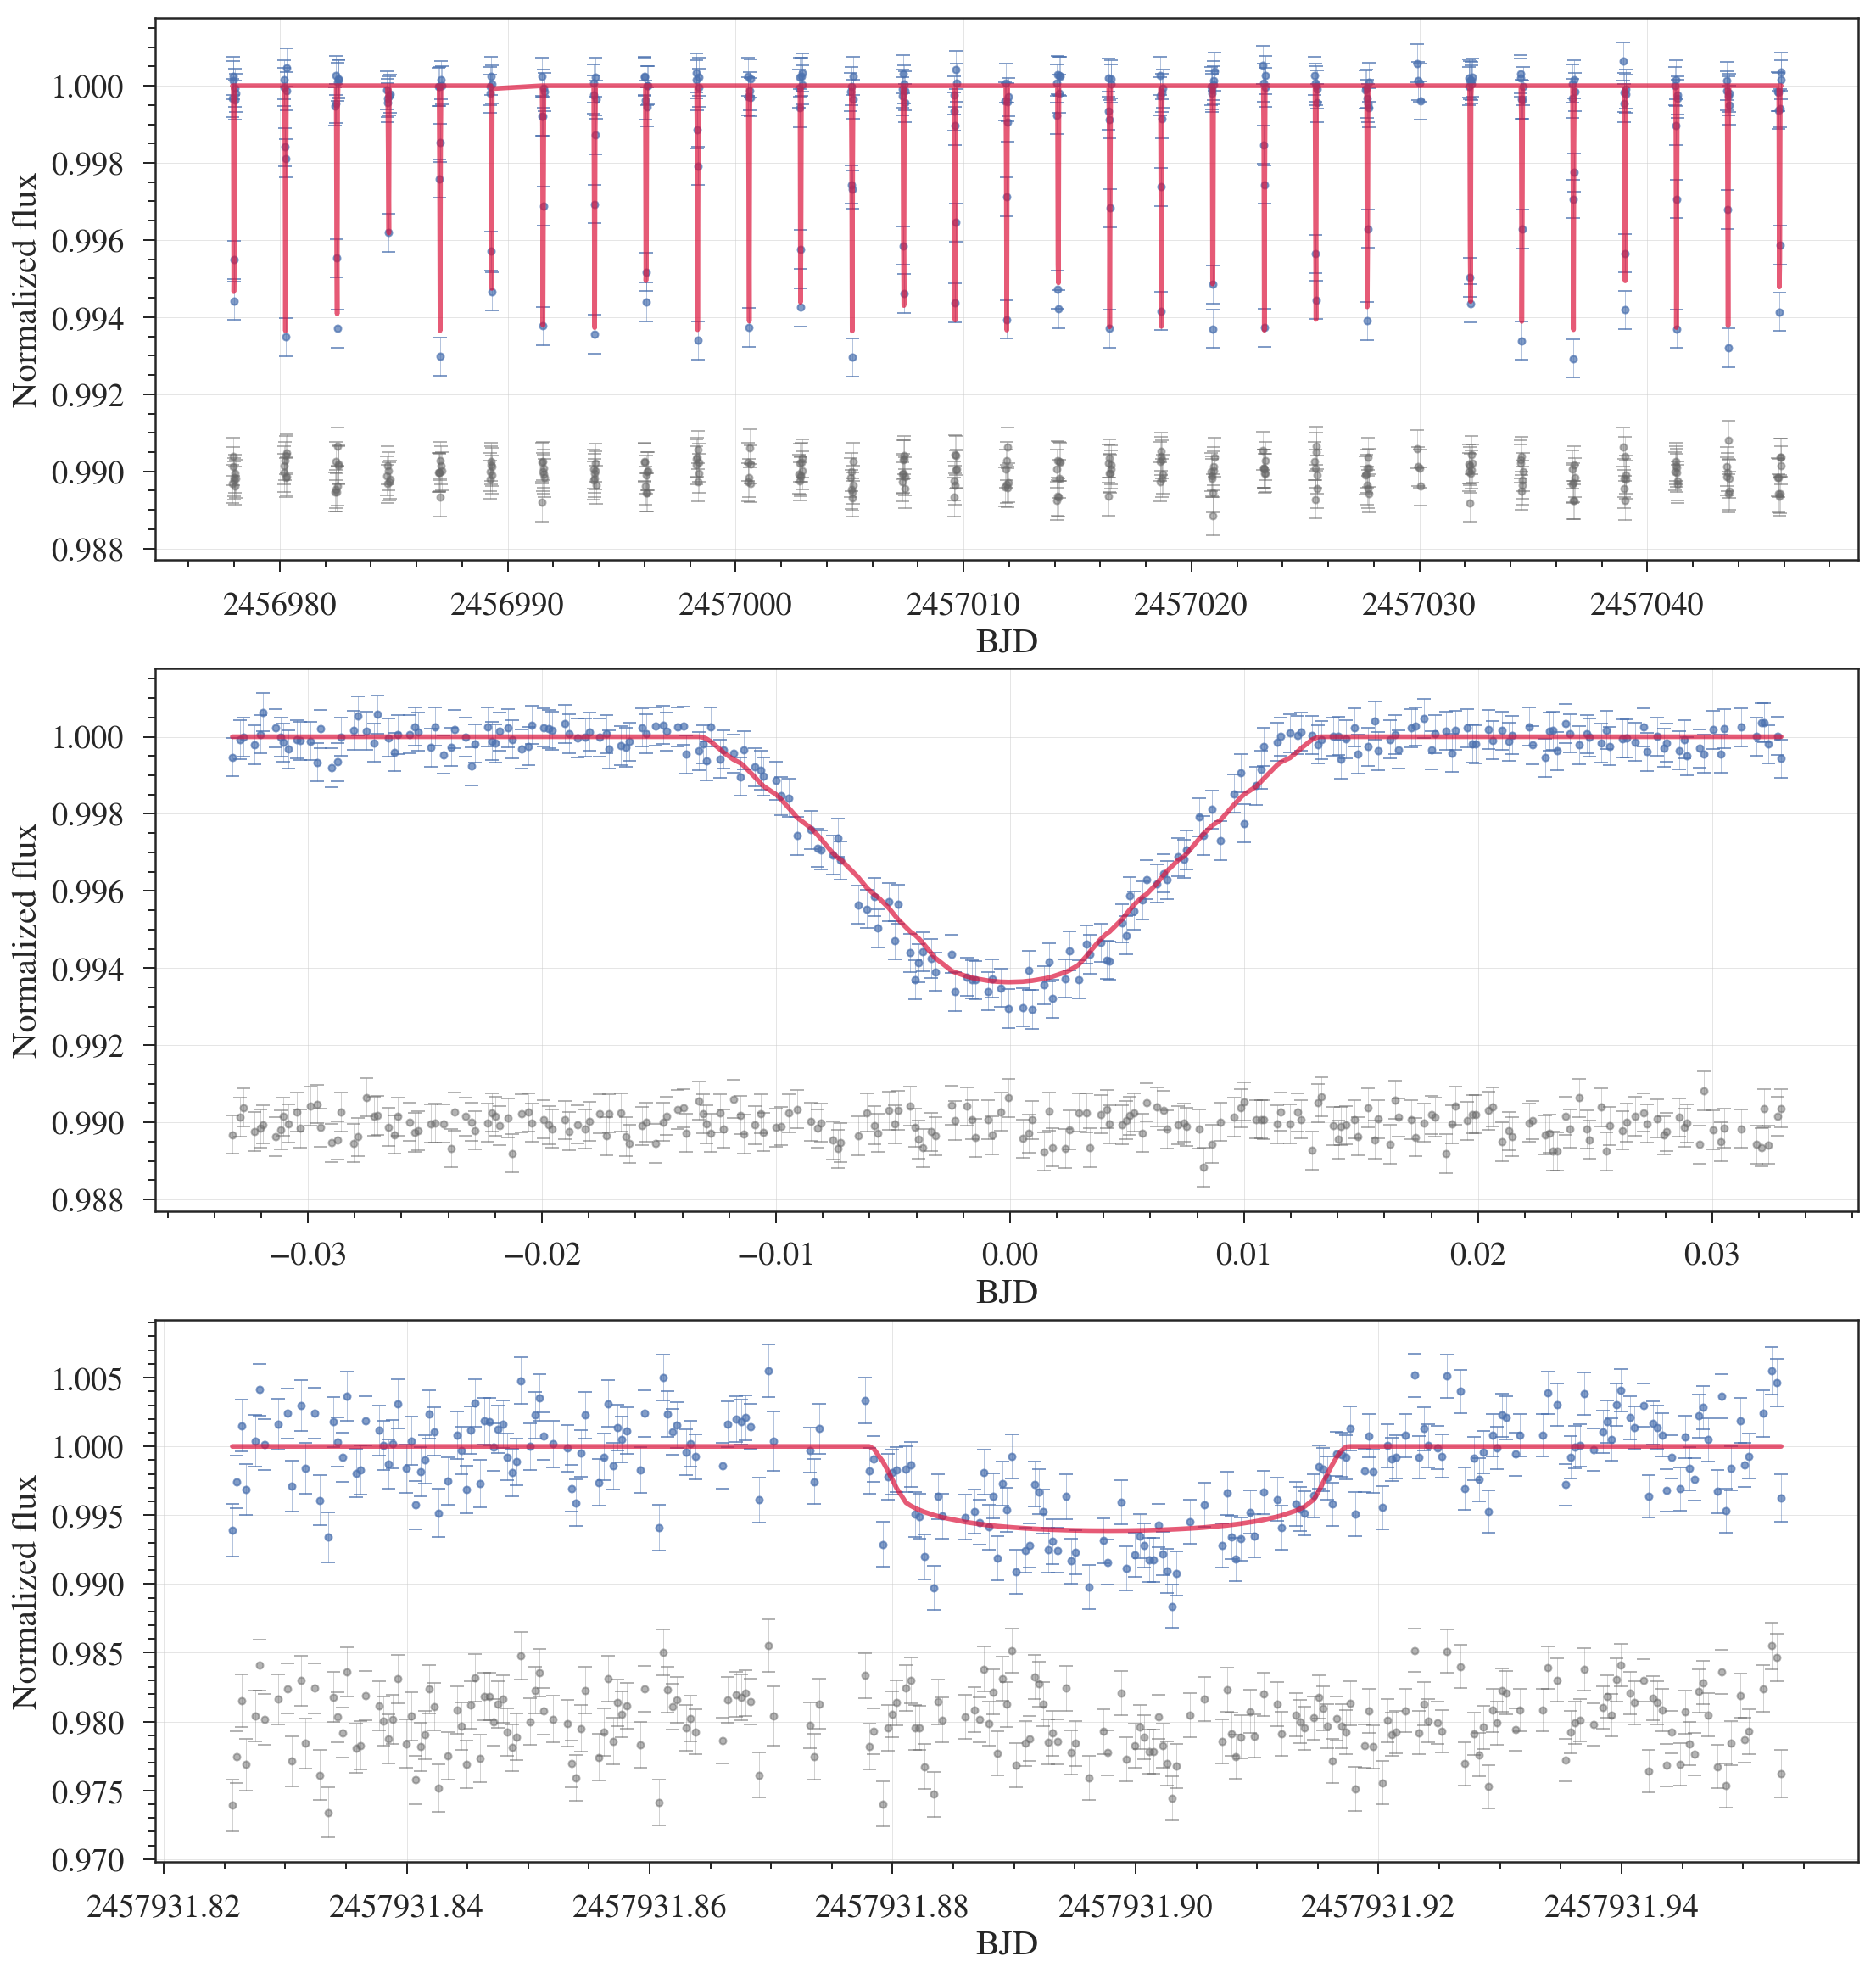

In [16]:
pv = TF.min_pv
t0  = pv[0]
p  = 10.**(pv[1])
phases_data = utils.get_phases(TF.lpf.data1["time"],p,t0)
phases_fit = utils.get_phases(TF.lpf.data1["time"],p,t0)

model_trend1, model_trend2 = TF.lpf.compute_lc_model(pv)

scaled_flux1 = TF.lpf.data1["flux"]/pv[TF.lpf.pv_lab2Idx("fraw1")]
scaled_flux2 = TF.lpf.data2["flux"]/pv[TF.lpf.pv_lab2Idx("fraw2")]

df_fold = pd.DataFrame(zip(phases_fit,model_trend1,scaled_flux1),columns=["phase","model","scaled_flux"]).sort_values("phase")

residual1 = scaled_flux1 - model_trend1
residual2 = scaled_flux2 - model_trend2

scaled_error1 = pv[TF.lpf.pv_lab2Idx("err1")]/pv[TF.lpf.pv_lab2Idx("fraw1")]
scaled_error2 = TF.lpf.data2["error"]/pv[TF.lpf.pv_lab2Idx("fraw2")]

# Plot transits
fig, axx = plt.subplots(nrows=3,figsize=(18,20))
ax,bx,cx = axx
plot_transits.plot_transit_with_model(TF.lpf.data1["time"],
                        scaled_flux1,
                        scaled_error1,
                        yresidual=residual1,
                        xmodel=TF.lpf.data1["time"],
                        ymodel=model_trend1,ax=ax)
plot_transits.plot_transit_with_model(df_fold.phase,
                        df_fold.scaled_flux,
                        scaled_error1,
                        yresidual=residual1,
                        xmodel=df_fold.phase,
                        ymodel=df_fold.model,ax=bx)
plot_transits.plot_transit_with_model(TF.lpf.data2["time"],
                        scaled_flux2,
                        scaled_error2,
                        yresidual=residual2,
                        xmodel=TF.lpf.data2["time"],
                        ymodel=model_trend2,
                        offset=0.98,ax=cx)

In [37]:
TF.minimize_PyDE(mc_iter=4000)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
      labels       centers         lower         upper            pv  center_dist
0         tc  2.457932e+06  2.457932e+06  2.457932e+06  2.457932e+06    -0.000654
1       logP  3.541924e-01  3.521924e-01  3.561924e-01  3.541962e-01    -0.000004
2     cos(i)  1.000000e-01  0.000000e+00  2.000000e-01  4.946377e-02     0.050536
3     RpRs_1  5.000000e-02  0.000000e+00  1.000000e-01  7.126959e-02    -0.021270
4  log(a/Rs)  1.450000e+00  9.000000e-01  2.000000e+00  1.171017e+00     0.278983
5     RpRs_2  5.000000e-02  0.000000e+00  1.000000e-01  7.721144e-02    -0.027211
6      fraw1  1.000000e+00  9.000000e-01  1.100000e+00  9.991562e-01     0.000844
7      fraw2  1.000000e+00  9.000000e-01  1.100000e+00  1.000965e+00    -0.000965
8       err1  2.550000e-04  1.000000e-05  5.000000e-04  4.986692e-04    -0.000244
LogLn value: -2052.6281277057583
Log priors 24.78332492492725
Running MCMC
MCMC iterations= 4000


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

1862 1863 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 

3501 3502 3503 3504 3505 3506 3507 3508 3509 3510 3511 3512 3513 3514 3515 3516 3517 3518 3519 3520 3521 3522 3523 3524 3525 3526 3527 3528 3529 3530 3531 3532 3533 3534 3535 3536 3537 3538 3539 3540 3541 3542 3543 3544 3545 3546 3547 3548 3549 3550 3551 3552 3553 3554 3555 3556 3557 3558 3559 3560 3561 3562 3563 3564 3565 3566 3567 3568 3569 3570 3571 3572 3573 3574 3575 3576 3577 3578 3579 3580 3581 3582 3583 3584 3585 3586 3587 3588 3589 3590 3591 3592 3593 3594 3595 3596 3597 3598 3599 3600 3601 3602 3603 3604 3605 3606 3607 3608 3609 3610 3611 3612 3613 3614 3615 3616 3617 3618 3619 3620 3621 3622 3623 3624 3625 3626 3627 3628 3629 3630 3631 3632 3633 3634 3635 3636 3637 3638 3639 3640 3641 3642 3643 3644 3645 3646 3647 3648 3649 3650 3651 3652 3653 3654 3655 3656 3657 3658 3659 3660 3661 3662 3663 3664 3665 3666 3667 3668 3669 3670 3671 3672 3673 3674 3675 3676 3677 3678 3679 3680 3681 3682 3683 3684 3685 3686 3687 3688 3689 3690 3691 3692 3693 3694 3695 3696 3697 3698 3699 3700 

Plotting chains


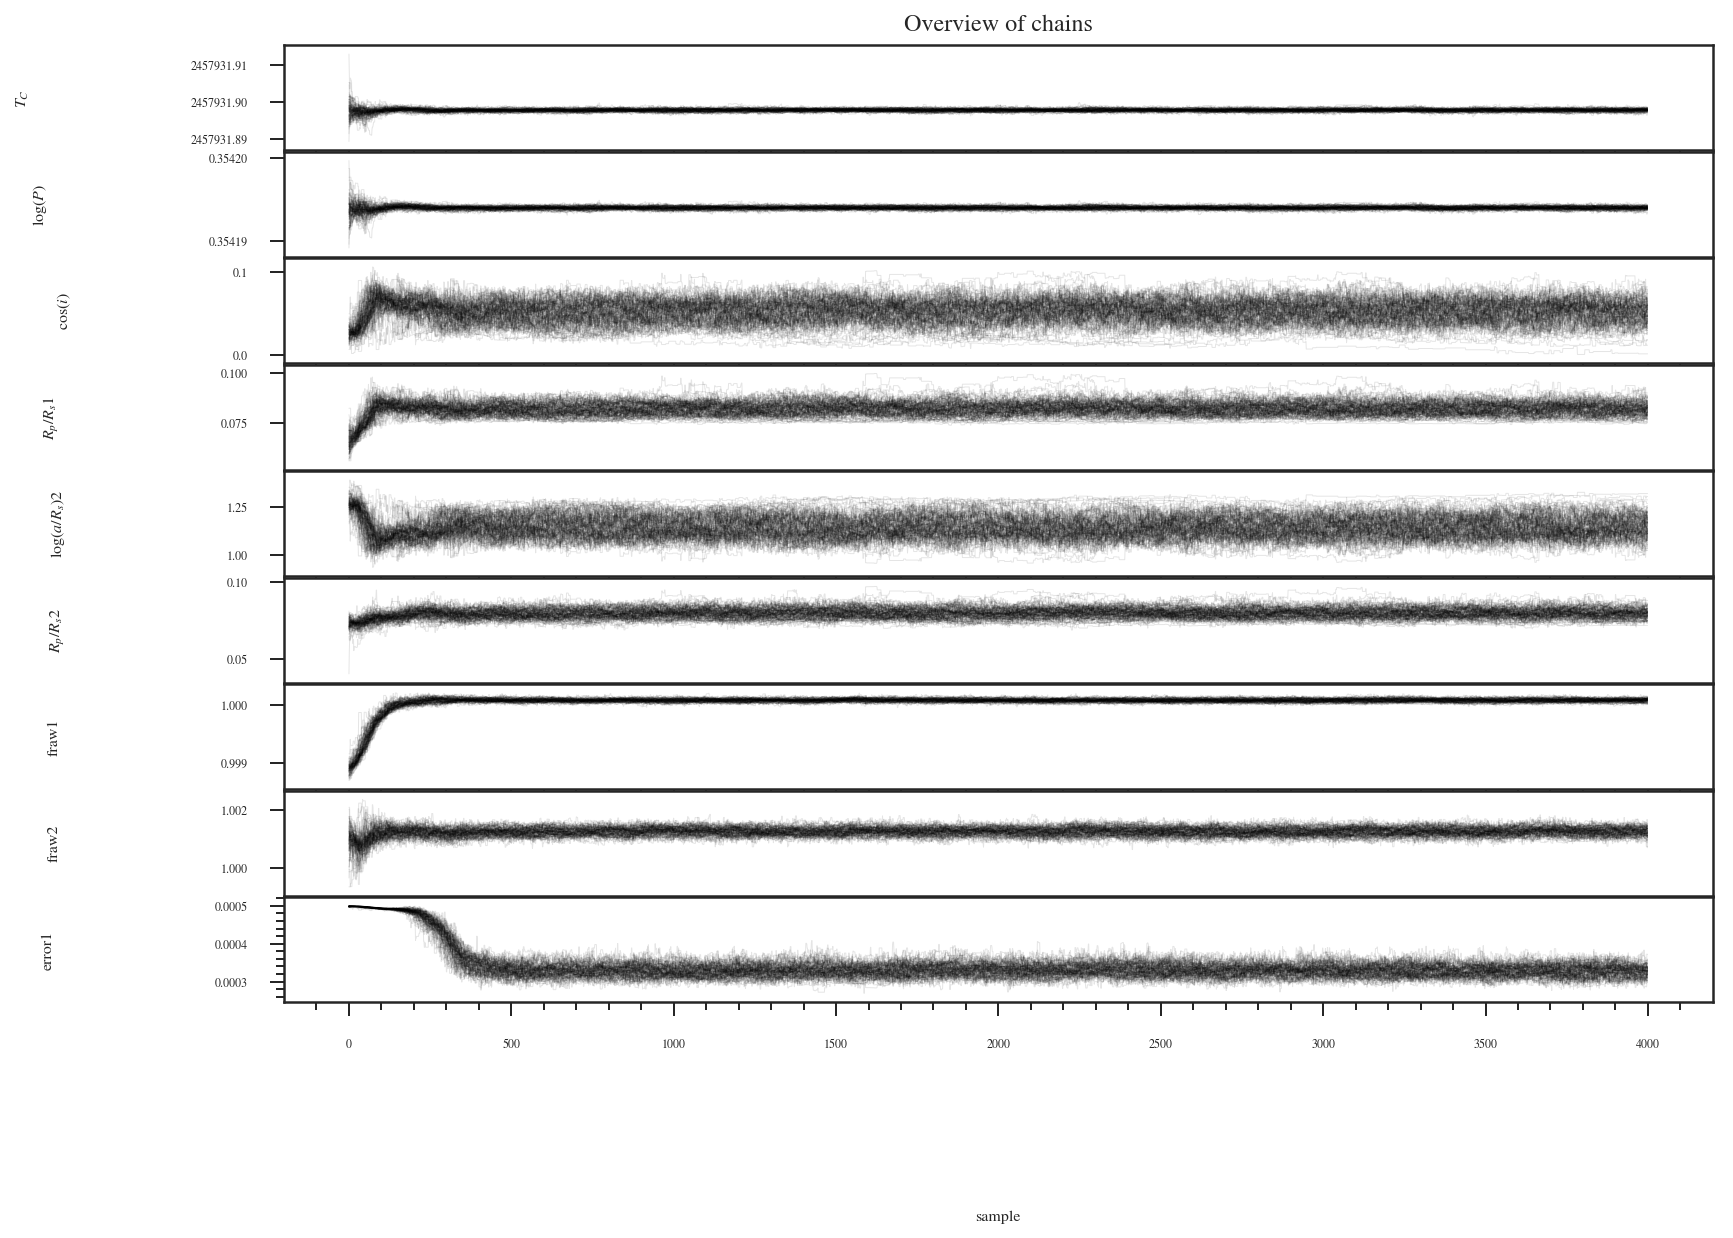

In [38]:
TF.plot_chains(burn=0)

Plotting chains


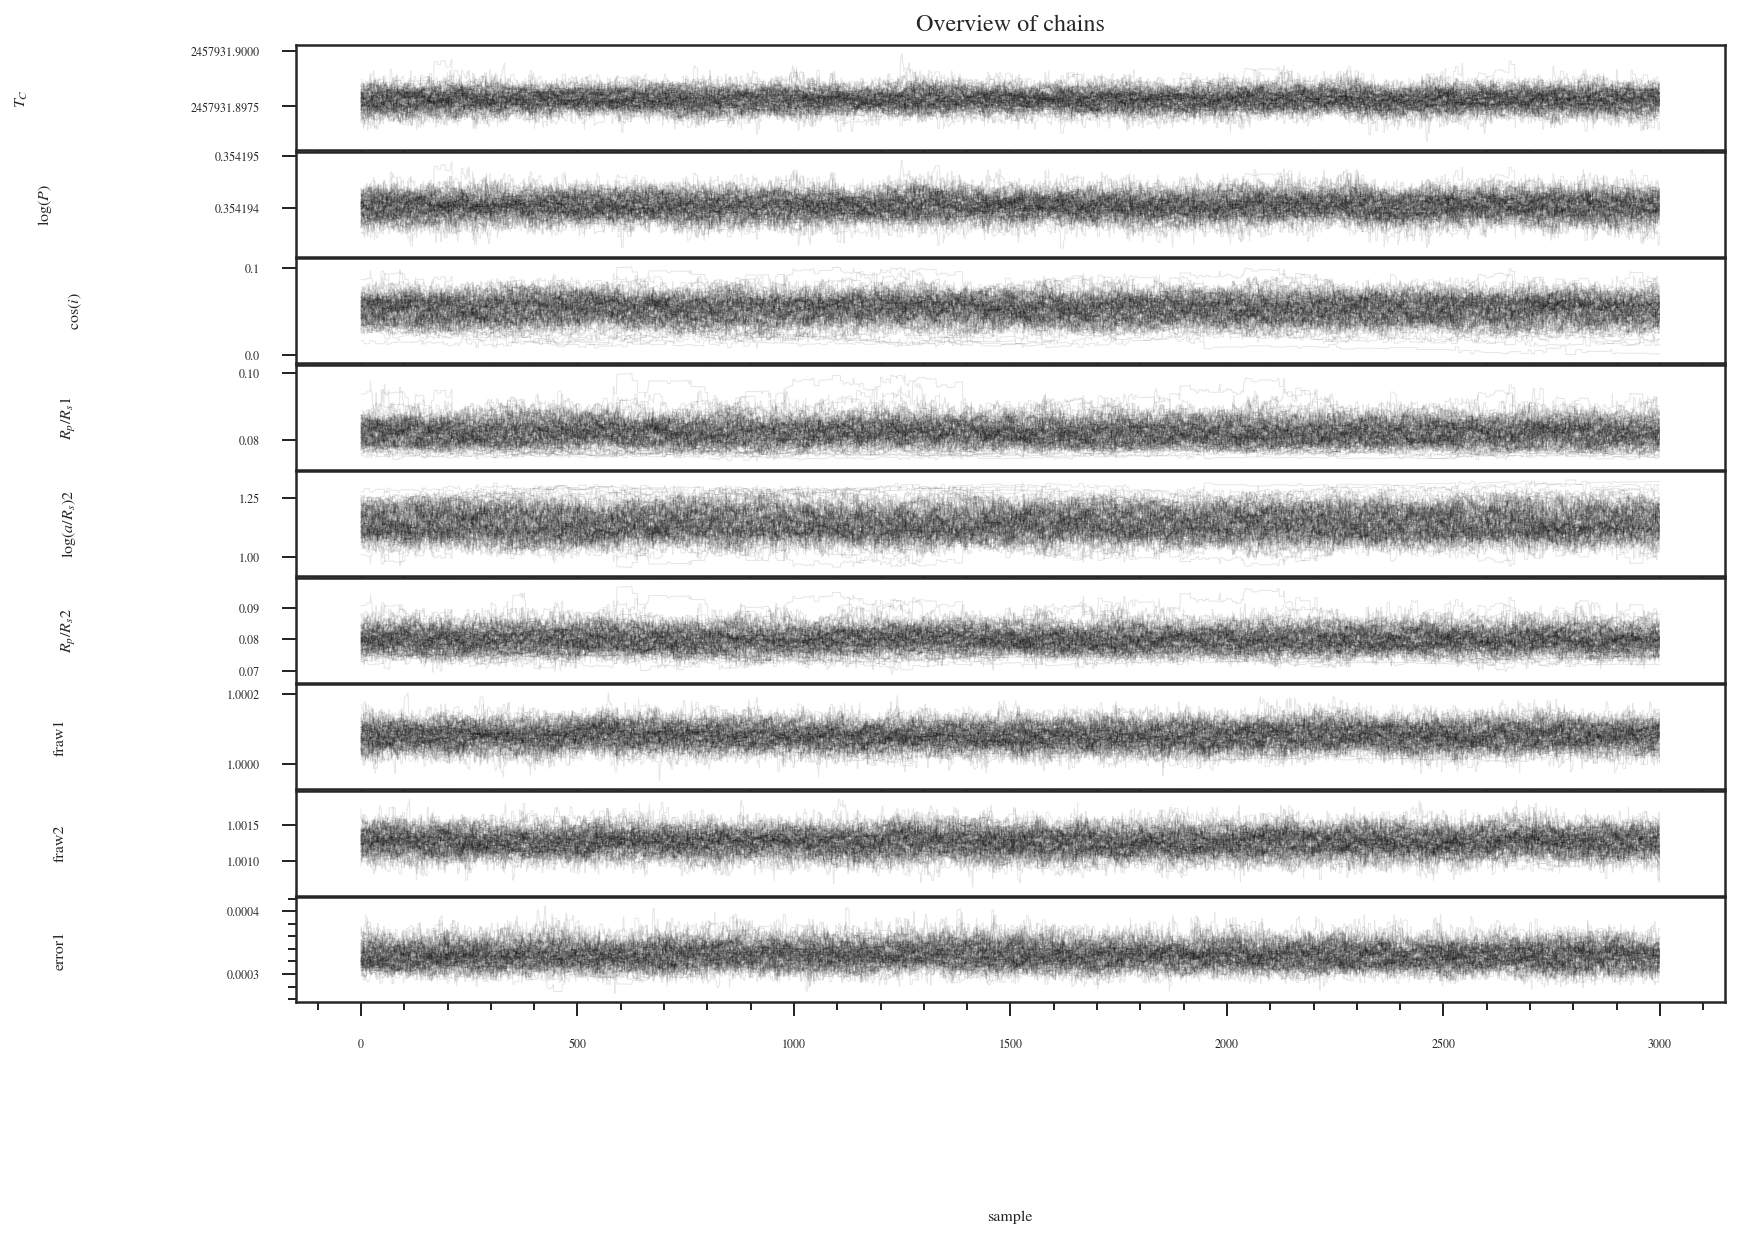

In [39]:
TF.plot_chains(burn=1000)

Plotting cornerplot


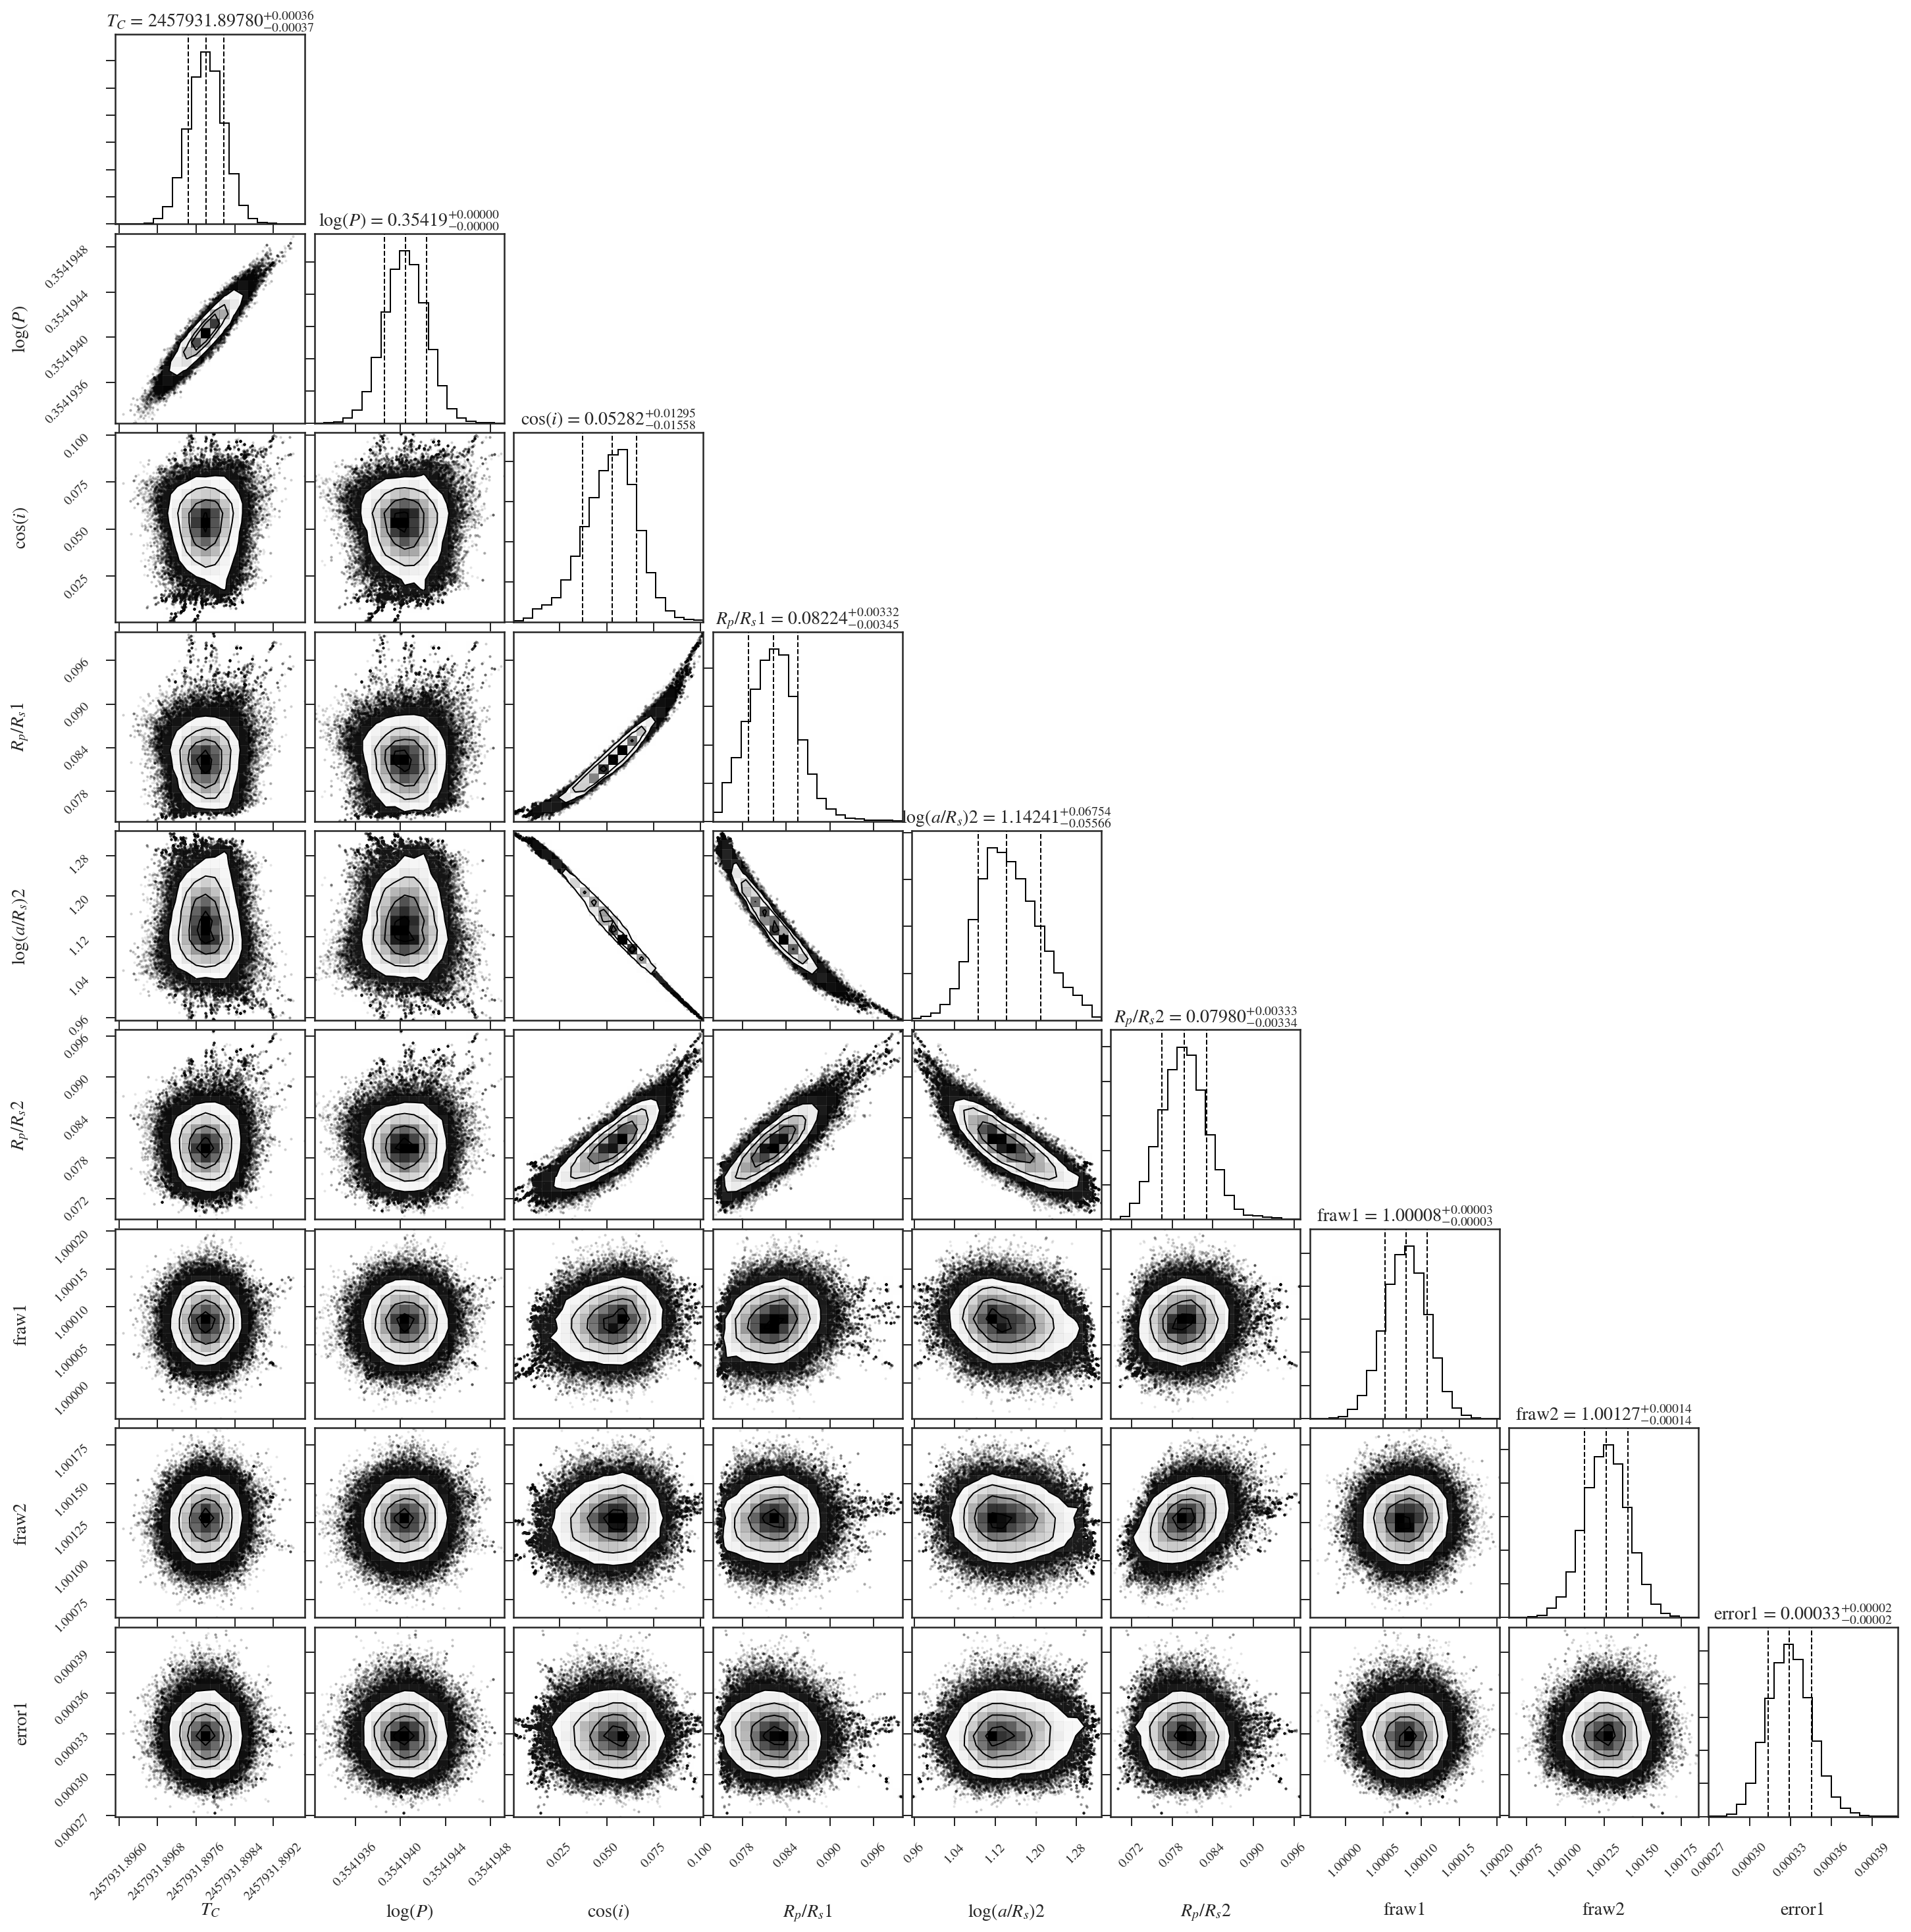

In [40]:
TF.plot_corner(burn=1000,show_titles=True)

In [26]:
TF.gelman_rubin()

array([1.01711866, 1.0164901 , 1.03295128, 1.02864069, 1.03104877,
       1.02618701, 1.00336852, 1.01558529, 1.00218837])

In [43]:
df = TF.get_df_flatchain(burn=1000)

In [44]:
df["P"] = 10.**df["logP"].values
df["i"] = np.rad2deg(np.arccos(df["cos(i)"].values))
df["aRs"] = 10.**df["log(a/Rs)"].values
# K2 parameters
df_param_k2 = TF.get_transit_parameters_from_arrays(df['tc'].values,
                                                 df['P'].values,
                                                 df['i'].values,
                                                 df['RpRs_1'].values,
                                                 df['aRs'].values,
                                                 st_rad=0.288,
                                                 st_raderr1=0.028,
                                                 st_teff=3214.,
                                                 st_teff_err1=60.)
# Ground based parameters
df_param_ground = TF.get_transit_parameters_from_arrays(df['tc'].values,
                                                 df['P'].values,
                                                 df['i'].values,
                                                 df['RpRs_2'].values,
                                                 df['aRs'].values,
                                                 st_rad=0.288,
                                                 st_raderr1=0.028,
                                                 st_teff=3214.,
                                                 st_teff_err1=60.)

Assuming
R_s: 0.288 +- 0.028
Teff: 3214.0 +- 60.0
Albedo: 0.3
Assuming
R_s: 0.288 +- 0.028
Teff: 3214.0 +- 60.0
Albedo: 0.3


### Ground-based parameters

In [45]:
df_param_ground

medvals         minus          plus  \
0   2.457932e+06  3.667343e-04  3.629639e-04   
1   2.260446e+00  9.674747e-07  9.665130e-07   
2   7.979627e-02  3.342597e-03  3.327898e-03   
3   2.504349e+00  2.601117e-01  2.682746e-01   
4   2.234235e-01  2.320565e-02  2.393390e-02   
5   6.367445e-03  5.222806e-04  5.421827e-04   
6   1.388051e+01  1.669793e+00  2.335688e+00   
7   1.861291e-02  2.847678e-03  3.634983e-03   
8   9.901035e+00  3.160607e+00  5.886397e+00   
9   8.697243e+01  7.431906e-01  8.935723e-01   
10  7.329390e-01  1.290485e-01  7.019365e-02   
11  0.000000e+00  0.000000e+00  0.000000e+00   
12  0.000000e+00  0.000000e+00  0.000000e+00   
13  4.267277e+02  3.274145e+01  2.971425e+01   
14  2.301288e+01  6.290738e+00  7.110927e+00   
15  4.120211e-02  1.655672e-03  1.750550e-03   
16  6.143344e-03  1.840362e-03  2.215201e-03   
17  2.457933e+06  3.671288e-04  3.633327e-04   

                                    values  \
0     $2457931.8978_{-0.00037}^{+0.00036}$   
1   $2.26044551_{-0.0000010}^{+0.0000010}$   
2             $0.0798_{-0.0033}^{+0.0033}$   
3                    $2.5_{-0.26}^{+0.27}$   
4                $0.223_{-0.023}^{+0.024}$   
5          $0.00637_{-0.00052}^{+0.00054}$   
6                     $13.9_{-1.7}^{+2.3}$   
7             $0.0186_{-0.0028}^{+0.0036}$   
8                      $9.9_{-3.2}^{+5.9}$   
9                  $86.97_{-0.74}^{+0.89}$   
10                $0.733_{-0.13}^{+0.070}$   
11                     $0.0_{-0.0}^{+0.0}$   
12                     $0.0_{-0.0}^{+0.0}$   
13                 $427.0_{-33.0}^{+30.0}$   
14                    $23.0_{-6.3}^{+7.1}$   
15            $0.0412_{-0.0017}^{+0.0018}$   
16            $0.0061_{-0.0018}^{+0.0022}$   
17   $2457933.02803_{-0.00037}^{+0.00036}$   

                                               Labels  \
0                      $T_{0}$ $(\mathrm{BJD_{TDB}})$   
1                                          $P$ (days)   
2                                           $R_p/R_*$   
3                                    $R_p (R_\oplus)$   
4                                         $R_p (R_J)$   
5                                            $\delta$   
6                                             $a/R_*$   
7                                            $a$ (AU)   
8   $\rho_{\mathrm{*,transit}}$ ($\mathrm{g/cm^{3}}$)   
9                                    $i$ $(^{\circ})$   
10                                                $b$   
11                                                $e$   
12                              $\omega$ ($^{\circ}$)   
13                              $T_{\mathrm{eq}}$ (K)   
14                                 $S$ ($S_{\oplus}$)   
15                                    $T_{14}$ (days)   
16                                      $\tau$ (days)   
17                     $T_{S}$ $(\mathrm{BJD_{TDB}})$   

                             Description  
0                       Transit Midpoint  
1                         Orbital period  
2                           Radius ratio  
3                          Planet radius  
4                          Planet radius  
5                          Transit depth  
6              Normalized orbital radius  
7                        Semi-major axis  
8                        Density of star  
9                    Transit inclination  
10                      Impact parameter  
11                          Eccentricity  
12                Argument of periastron  
13  Equilibrium temp. (assuming $a=0.3$)  
14                       Insolation Flux  
15                      Transit duration  
16               Ingress/egress duration  
17             Time of secondary eclipse

### Parameters from K2 

In [46]:
df_param_k2

medvals         minus          plus  \
0   2.457932e+06  3.667343e-04  3.629639e-04   
1   2.260446e+00  9.674747e-07  9.665130e-07   
2   8.224393e-02  3.451152e-03  3.318231e-03   
3   2.579662e+00  2.675351e-01  2.764074e-01   
4   2.301424e-01  2.386792e-02  2.465946e-02   
5   6.764064e-03  5.557621e-04  5.568193e-04   
6   1.388051e+01  1.669793e+00  2.335688e+00   
7   1.860675e-02  2.850104e-03  3.635866e-03   
8   9.901035e+00  3.160607e+00  5.886397e+00   
9   8.697243e+01  7.431906e-01  8.935723e-01   
10  7.329390e-01  1.290485e-01  7.019365e-02   
11  0.000000e+00  0.000000e+00  0.000000e+00   
12  0.000000e+00  0.000000e+00  0.000000e+00   
13  4.267585e+02  3.271189e+01  2.954779e+01   
14  2.301954e+01  6.287136e+00  7.068488e+00   
15  4.137739e-02  1.719527e-03  1.816718e-03   
16  6.340462e-03  1.930968e-03  2.314904e-03   
17  2.457933e+06  3.671288e-04  3.633327e-04   

                                    values  \
0     $2457931.8978_{-0.00037}^{+0.00036}$   
1   $2.26044551_{-0.0000010}^{+0.0000010}$   
2             $0.0822_{-0.0035}^{+0.0033}$   
3                   $2.58_{-0.27}^{+0.28}$   
4                 $0.23_{-0.024}^{+0.025}$   
5          $0.00676_{-0.00056}^{+0.00056}$   
6                     $13.9_{-1.7}^{+2.3}$   
7             $0.0186_{-0.0029}^{+0.0036}$   
8                      $9.9_{-3.2}^{+5.9}$   
9                  $86.97_{-0.74}^{+0.89}$   
10                $0.733_{-0.13}^{+0.070}$   
11                     $0.0_{-0.0}^{+0.0}$   
12                     $0.0_{-0.0}^{+0.0}$   
13                 $427.0_{-33.0}^{+30.0}$   
14                    $23.0_{-6.3}^{+7.1}$   
15            $0.0414_{-0.0017}^{+0.0018}$   
16            $0.0063_{-0.0019}^{+0.0023}$   
17   $2457933.02803_{-0.00037}^{+0.00036}$   

                                               Labels  \
0                      $T_{0}$ $(\mathrm{BJD_{TDB}})$   
1                                          $P$ (days)   
2                                           $R_p/R_*$   
3                                    $R_p (R_\oplus)$   
4                                         $R_p (R_J)$   
5                                            $\delta$   
6                                             $a/R_*$   
7                                            $a$ (AU)   
8   $\rho_{\mathrm{*,transit}}$ ($\mathrm{g/cm^{3}}$)   
9                                    $i$ $(^{\circ})$   
10                                                $b$   
11                                                $e$   
12                              $\omega$ ($^{\circ}$)   
13                              $T_{\mathrm{eq}}$ (K)   
14                                 $S$ ($S_{\oplus}$)   
15                                    $T_{14}$ (days)   
16                                      $\tau$ (days)   
17                     $T_{S}$ $(\mathrm{BJD_{TDB}})$   

                             Description  
0                       Transit Midpoint  
1                         Orbital period  
2                           Radius ratio  
3                          Planet radius  
4                          Planet radius  
5                          Transit depth  
6              Normalized orbital radius  
7                        Semi-major axis  
8                        Density of star  
9                    Transit inclination  
10                      Impact parameter  
11                          Eccentricity  
12                Argument of periastron  
13  Equilibrium temp. (assuming $a=0.3$)  
14                       Insolation Flux  
15                      Transit duration  
16               Ingress/egress duration  
17             Time of secondary eclipse

In [47]:
df_k2_28b_jointground_final=pd.DataFrame({'Labels': df_param_ground['Labels'],'Description':df_param_ground['Description'],'Ground': df_param_ground['values']})
#df_k2_28b_final
df_k2_28b_jointground_final.to_csv('../data/k2_28b/k2-28b_jointground_for_latex_table.csv')

In [48]:
df_k2_28b_jointk2_final=pd.DataFrame({'Labels': df_param_k2['Labels'],'Description':df_param_k2['Description'],'K2': df_param_k2['values']})
#df_k2_28b_final
df_k2_28b_jointk2_final.to_csv('../data/k2_28b/k2-28b_jointk2_for_latex_table.csv')

# Plot with MCMC joint parameters

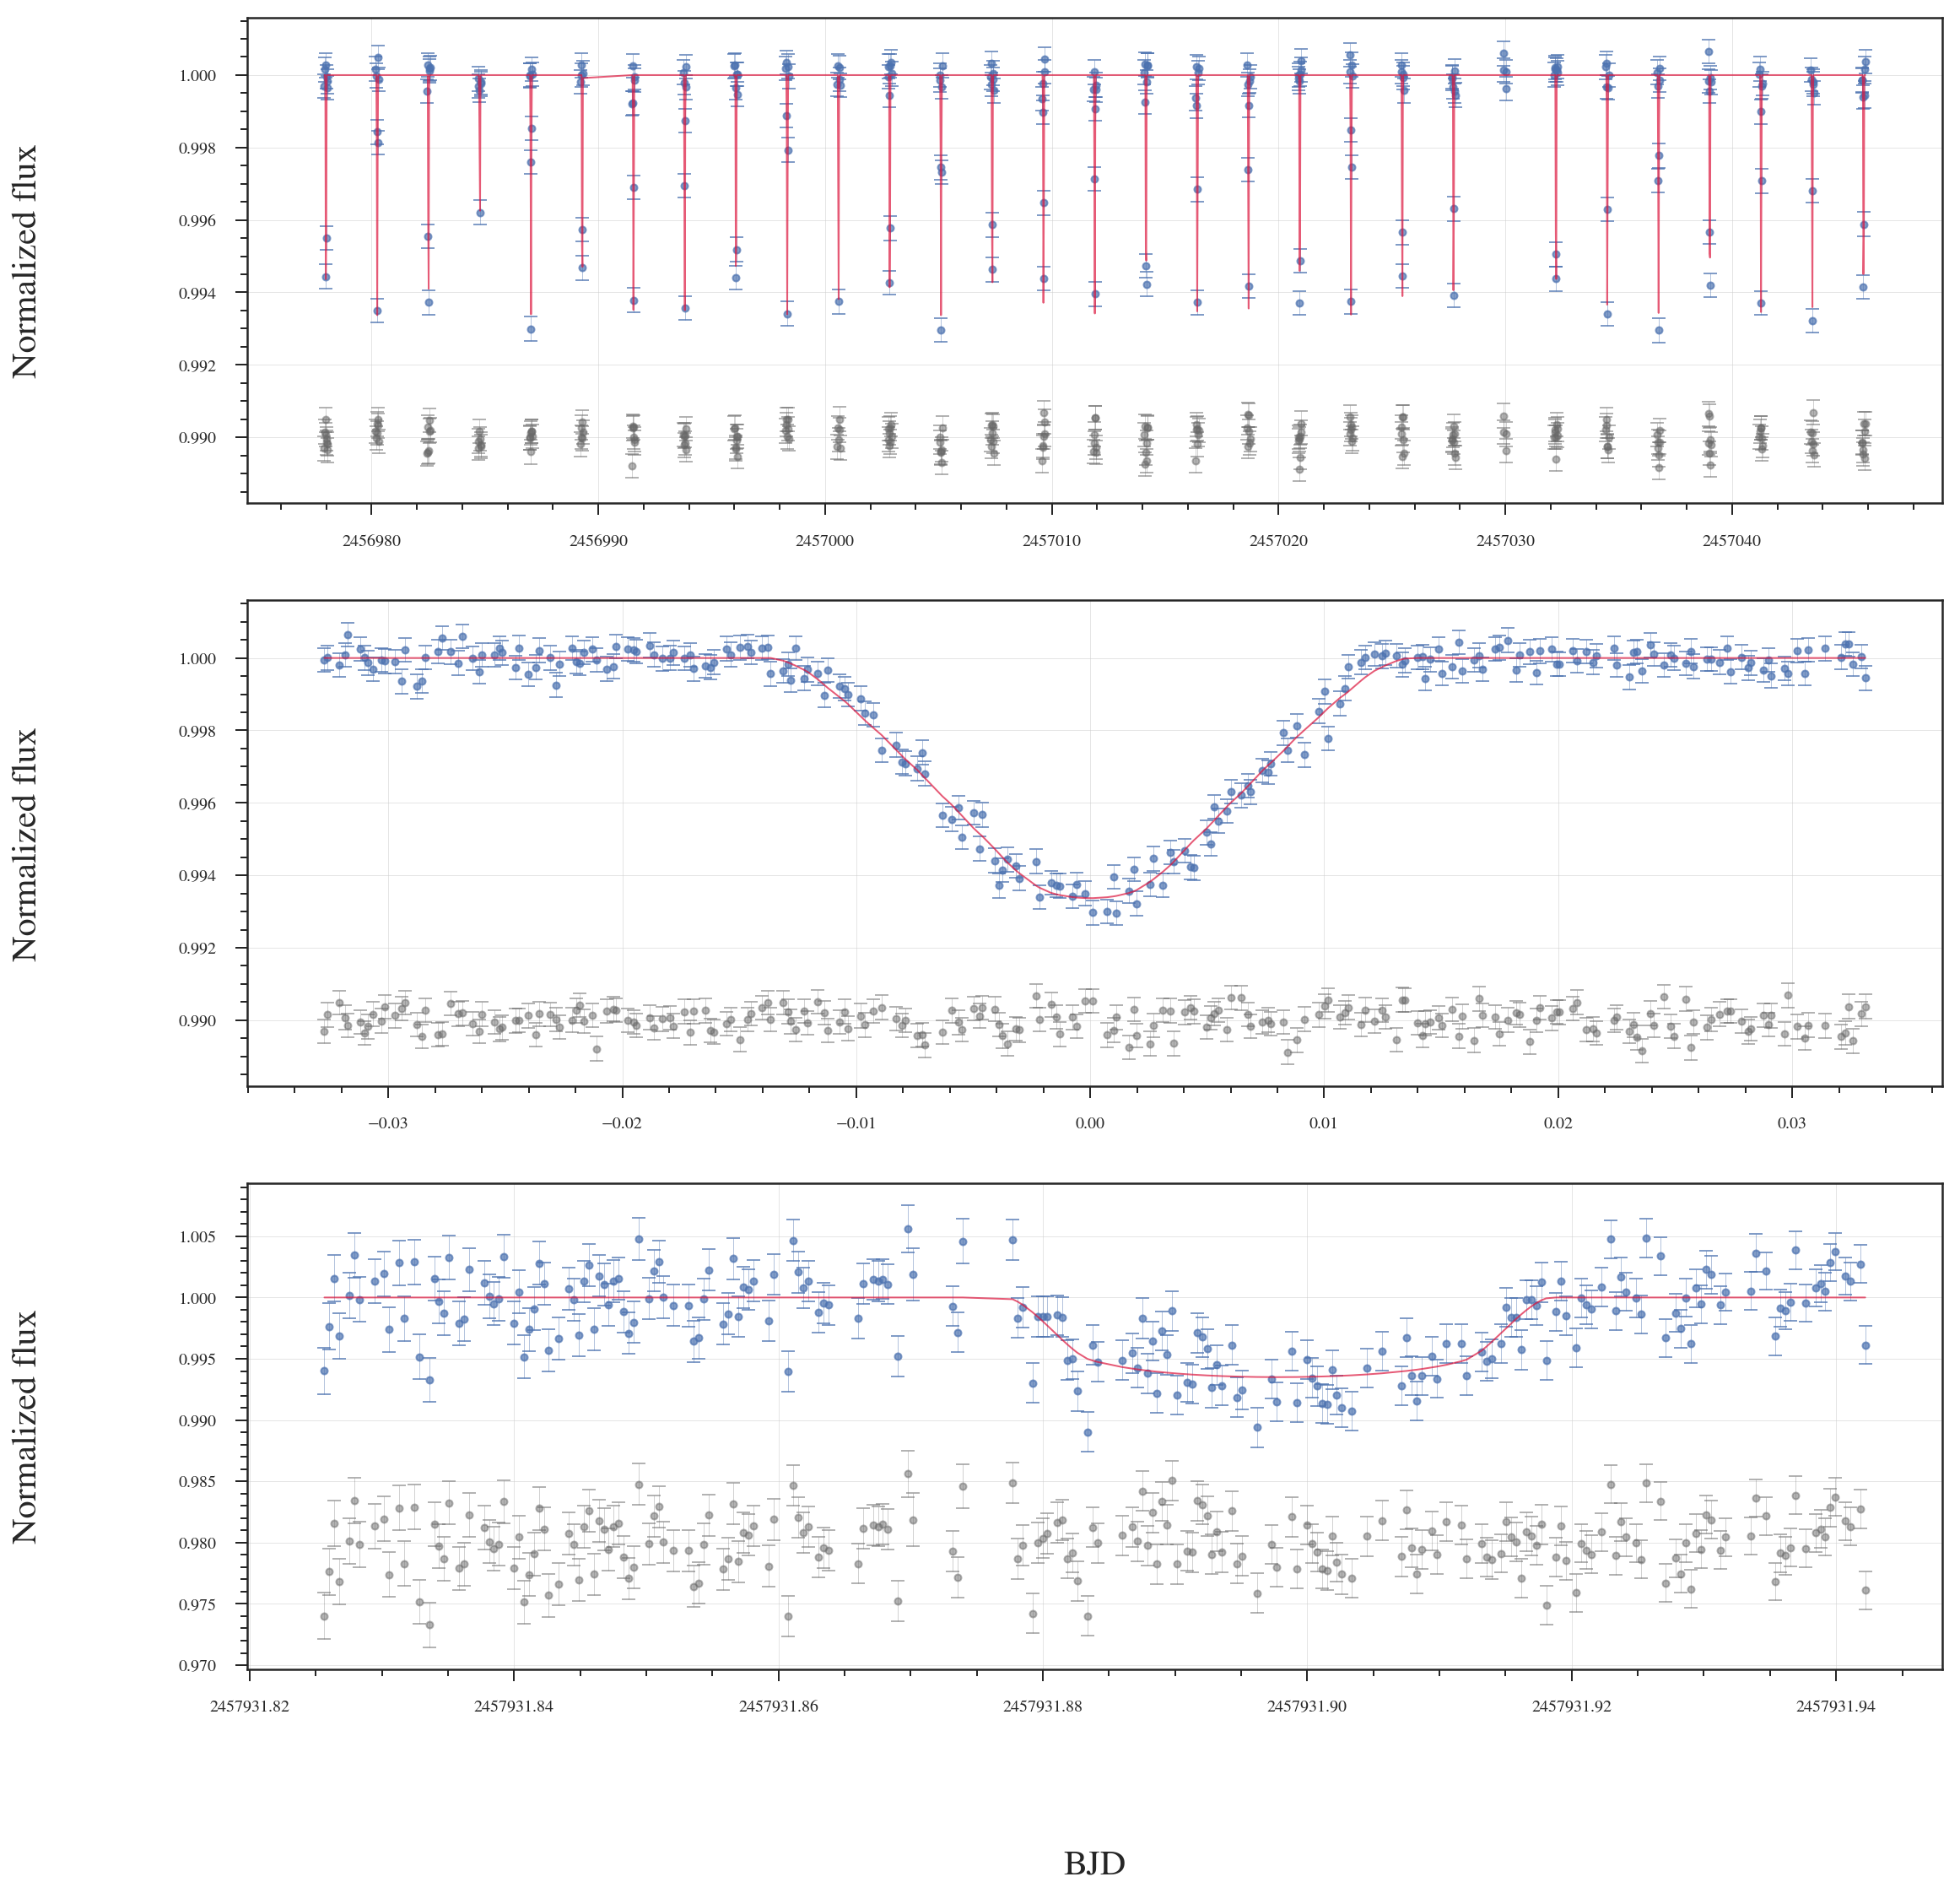

In [49]:
pv = TF.get_mean_values_mcmc_posteriors().medvals.values
t0  = TF.get_mean_values_mcmc_posteriors().medvals.values[0]
p  = 10.**TF.get_mean_values_mcmc_posteriors().medvals.values[1]
phases_data = utils.get_phases(TF.lpf.data1["time"],p,t0)
phases_fit = utils.get_phases(TF.lpf.data1["time"],p,t0)

model_trend1, model_trend2 = TF.lpf.compute_lc_model(pv)

scaled_flux1 = TF.lpf.data1["flux"]/pv[TF.lpf.pv_lab2Idx("fraw1")]
scaled_flux2 = TF.lpf.data2["flux"]/pv[TF.lpf.pv_lab2Idx("fraw2")]

df_fold = pd.DataFrame(zip(phases_fit,model_trend1,scaled_flux1),columns=["phase","model","scaled_flux"]).sort_values("phase")

residual1 = scaled_flux1 - model_trend1
residual2 = scaled_flux2 - model_trend2

scaled_error1 = pv[TF.lpf.pv_lab2Idx("err1")]/pv[TF.lpf.pv_lab2Idx("fraw1")]
scaled_error2 = TF.lpf.data2["error"]/pv[TF.lpf.pv_lab2Idx("fraw2")]

# Plot transits
fig, axx = plt.subplots(nrows=3,figsize=(18,18))
ax,bx,cx = axx
plot_transits.plot_transit_with_model(TF.lpf.data1["time"],
                        scaled_flux1,
                        scaled_error1,
                        yresidual=residual1,
                        xmodel=TF.lpf.data1["time"],
                        ymodel=model_trend1,ax=ax)
plot_transits.plot_transit_with_model(df_fold.phase,
                        df_fold.scaled_flux,
                        scaled_error1,
                        yresidual=residual1,
                        xmodel=df_fold.phase,
                        ymodel=df_fold.model,ax=bx)
plot_transits.plot_transit_with_model(TF.lpf.data2["time"],
                        scaled_flux2,
                        scaled_error2,
                        yresidual=residual2,
                        xmodel=TF.lpf.data2["time"],
                        ymodel=model_trend2,
                        offset=0.98,ax=cx)